# Forecasting Value at Risk

## Exploratory Data Analysis

In [ ]:
from yahooquery import Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

price = Ticker('AAPL').history(start='2010-01-01', interval='1d')
price.reset_index(inplace=True)
price.drop('symbol', axis=1, inplace=True)
price.set_index('date', inplace=True)
price.head(5)

### Plots

In [ ]:
log_returns = np.log(price['adjclose'] / price['adjclose'].shift(1)).dropna()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 16))

price['adjclose'].plot(title='Price of AAPL (2010 to 2020)', ax=axes[0])
log_returns.plot(title='Log Returns of AAPL (2010 to 2020)', ax=axes[1])

In [ ]:
log_returns.hist(figsize=(14, 6), bins=100)
plt.title('Distribution of Log Returns')

### Summary Statistics

In [ ]:
# Some summary statistics
log_returns.describe()

In [ ]:
# Skewness and kurtosis:
from scipy.stats import kurtosis, skew
print('Skew:', skew(log_returns))
print('Excess Kurtosis:', kurtosis(log_returns))

### Testing for ARCH Effects

To determine whether the log return is *serially uncorrelated* but *dependent*, we check for significant correlation in the *squared log return* series and no correlation in the *non-squared log return* series. To do this, we examine the ACF plot of the log return series and the squared log return series:

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(log_returns, ax=axs[0], title='Log Returns')
plot_acf(log_returns**2, ax=axs[1], title='Squared Log Returns')
plt.show()

The highlighted region represents the 95% confidence interval. The zeroth lag is always strongly significant, because $Cov(r_t, r_t)$ is always equal to one. It is clear that the squared log returns possess strong autocorrelation, hence confirming the presence of conditional heteroscedasticity (ARCH effect).

However, the assumption of non-serially correlated *log returns* appears to be violated:

In [ ]:
plot_acf(log_returns, zero=False)
plt.show()

This suggests that serial correlation must be extracted using a model for the conditional mean - hence the use of ARMA.

Formally, we use the Ljung-Box test, which tests whether any group of autocorrelations of a time series are different from zero. The null hypothesis assumes no serial correlation up to the kth lag in the return series, whilst the alternative hypothesis assumes non-zero autocorrelation.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

_, pval = acorr_ljungbox(log_returns, lags=11, return_df=False)
_, pval0 = acorr_ljungbox(log_returns**2, lags=11, return_df=False)
print('Significance log returns:\n', pval<.05)
print('\n Significance squared log returns:\n', pval0<.05)

## Example: Fitting ARMA-GARCH for VaR Estimation

### ARMA(p,q) Order Determination

We use the functions defined in the previous notebooks to fit an *ARMA(p,q)-GARCH(1,1)* model with *normally distributed* innovations. The `order_determination` function from `armagarch.py` does a brute force search for all lags, $p$ and $q$, within the desired range and returns the model with the best (lowest) AIC score among all fitted models.

In [ ]:
import sys
sys.path.append('tools')
import armagarch as ag

In [ ]:
X = log_returns.values[-500:-1] * 100.0  # exclude last for forecasting later
result = ag.order_determination(X, 'norm', 5, 5, verbose=True)  # test for up to p=6 and q=6

In [ ]:
estimates = result[0]
p, q = result[1], result[2]

print('Estimated Coefficients:\n', estimates)

### Statistical Significance of Estimates

To assess the signifiance of the estimated coefficients, we use Student's t-test. To do this, we must compute the t-statistic. Let $\hat{\beta}$ be an estimator of some parameter $\beta$. The *t-statistic* is defined as:

\begin{equation}
    t_{\hat{\beta}} = \frac{\hat{\beta} - \beta_0}{\text{s.e.}\left(\hat{\beta}\right)}.
\end{equation}

We set the null hypothesis and alternative hypothesis being:

\begin{equation}
    H_0: \beta_0 = 0,\quad H_a: \beta_0 \neq 0.
\end{equation}


Therefore, the t-statistic for each coefficient is computed as:

\begin{equation}
    t_{\hat{\beta}} = \frac{\hat{\beta}}{\text{s.e.}\left(\hat{\beta}\right)}.
\end{equation}

Along with the assumption of *asymptotic normality* made when we used the Gaussian log likelihood function, we say that the quantity $\text{s.e.}\left(\hat{\beta}\right)$ estimates the asymptotic variance of this estimator. We compute the asymptotic variance using the *sandwich estimator*:

\begin{equation}
    \hat{J}\left(\hat{\theta}\right)^{-1} \hat{V}\left(\hat{\theta}\right) \hat{J}\left(\hat{\theta}\right)^{-1},
\end{equation}

which is implemented in `armagarch.py` using numerical methods. The `hessian_2sided` computes $\hat{J}$, while $\hat{V}$ is calculated by first computing the Jacobian, $l'(\theta)$:

\begin{equation}
    \hat{V}\left(\theta\right) = \sum_{i=1}^{n} l'_n(\theta)^2.
\end{equation}

This is all implemented in `get_summary_stats`, which returns the standard error, t-statistics and p-values:

In [ ]:
_, std_err, tstats, pvals = ag.get_summary_stats(X, estimates, 'norm', p, q, print_output=True)

## One-Step Forecast

Taking our previous example, we can create a one-step forecast by taking the expectation:

\begin{equation}
    E(r_{t+1}\vert r_t) = c + \sum_{i=1}^p \phi_i r_{t+1-i} + \sum_{j=1}^q \theta_j \epsilon_{t+1-j},
\end{equation}

where the residual term is omitted because $E(\epsilon_{t+1})=0$. Also, 

\begin{equation}
    \sigma_{t+1}^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t+1-i}^2 + \sum_{k=1}^q \beta_k \sigma_{t+1-k}^2
\end{equation}

### What is Value at Risk (VaR)?

*(Adapted from: Performance of ARMA-GARCH
models in Value at Risk estimation, Gabriella Sawma)*

Value at Risk (VaR) quantifies market risk by estimating the maximal loss that may occur under normal market ocnditions, given a corresponding confidence level and a time horizon (Jorion 2007). Statistically speaking, VaR is the 'left tail', or the 'loss' quantile of the distribution function of returns.

If $r$ is the observed log return and $\alpha \subseteq [0,1]$ denotes the confidence level between zero and one. The probability that VaR exceeds the return is expressed as

\begin{equation}
    \Pr (r < -\text{VaR}) = \alpha.
\end{equation}

Assuming a normal distribution with mean $\mu$ and standard deviation $\sigma$, then the $\text{VaR}^{\alpha}$ can be expressed as:

\begin{equation}
    \text{VaR}^{\alpha} = \mu - \sigma \Phi^{-1}(\alpha),
\end{equation}

where $\Phi$ denotes the cumulative distribution function for a standard normal distribution and $\Phi^{-1}(\alpha)$ calculates quantile mass for $\alpha$.

### Example (continued)

I have defined functions `one_step_prediction` and `VaR` to perform the steps described in Section 5.3.1 and 5.3.2:

In [ ]:
# Using the previous example

r_pred, sigma2_pred = ag.one_step_prediction(X, estimates, p, q)
r_pred = r_pred * 0.01  # scale back
sigma2_pred = sigma2_pred * 0.01**2  # scale back

print('Log Return Prediction:', r_pred)
print('Conditional Variance Prediction:', sigma2_pred)

In [ ]:
# 99% VaR
value_at_risk = ag.VaR('norm', r_pred, np.sqrt(sigma2_pred), 1-0.99)
print('Actual log return:', log_returns.values[-1])
print('99% Var:', value_at_risk)
print('Coverage:', log_returns.values[-1] > value_at_risk)

## Rolling Forecasts

We now perform a full backtest to assess the predictive power of our ARMA-GARCH models. To prevent look-ahead bias, I utilise a rolling window of the last 500 observations, and then perform a one-step-ahead forecast for the next day. 

### Implementation

Due to the high computational demands of the backtest, the backtest will be performed using *multiprocessing*. The code below can be found under `tools/backtest.py`.

In [1]:
import os
import pandas as pd

data_dir = 'data/var-forecasts'
fnames = os.listdir(data_dir)
dates, var_estimates, actual_log_returns = [], [], []

for file in fnames:
    with open(os.path.join(data_dir, file), 'r') as f:
        date, var, log_return = f.read().split(',')
        dates.append(date)
        var_estimates.append(float(var))
        actual_log_returns.append(float(log_return))
        f.close()

forecasts = pd.DataFrame(
    {'date': dates,
     'var_estimate': var_estimates,
     'log_return': actual_log_returns}
).set_index('date')
forecasts.index = pd.to_datetime(forecasts.index)
forecasts.sort_index(inplace=True)
forecasts.head(3)

,var_estimate,log_return
date,,
2012-10-11,-0.023348,-0.020190
2012-10-12,-0.023326,0.002560
2012-10-15,-0.027049,0.007987


### Visualising the Forecast Results

I plot the forecasted 5% VaR values and the actual daily log return. The red dots represent days in which the actual log return proved to be smaller than the 5% VaR: 

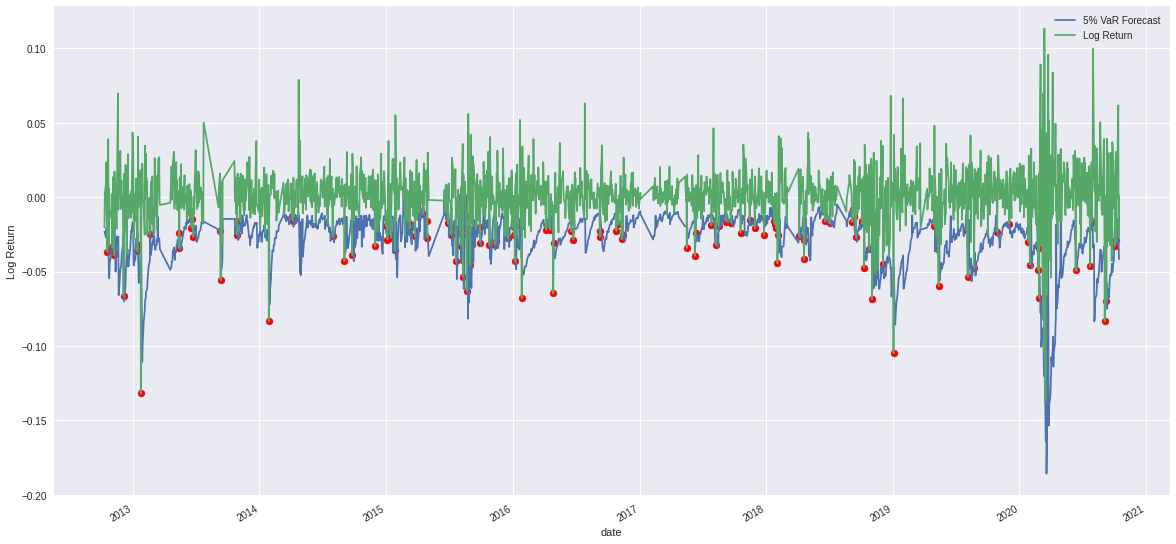

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

failed = forecasts[forecasts['log_return'] < forecasts['var_estimate']]['log_return']

forecasts.plot(figsize=(20, 10), ylabel='Log Return')
plt.legend(['5% VaR Forecast', 'Log Return'])
plt.scatter(failed.index, failed.values, color='red')

### Forecast Accuracy

There are a few ways to assess the predictive power of our model. The simplest being to see what proportion of 5% VaR forecasts provided cvoerage for the actual log return:

In [3]:
valcounts = (forecasts['log_return'] > forecasts['var_estimate']).value_counts()
n_false, n_true = valcounts[0], valcounts[1]
pred_acc = n_true / (n_false + n_true)
print('Test Period: ' + forecasts.index[0].strftime('%Y-%m-%d') + ' to ' + forecasts.index[-1].strftime('%Y-%m-%d'))
print('Total Predictions Made:', n_false+n_true)
print('Total Coverage:', pred_acc.round(5))

Test Period: 2012-10-11 to 2020-10-14
Total Predictions Made: 1818
Total Coverage: 0.92574


92.6% seems pretty good. However, we should use a more formal test to assess the suitability of this model. For this, we use the Christofferson's Conditional Coverage test. Let $n_{ij}$ be the number of observations with value $i$ followed by $j$ for $i,j=0,1$. Further, let $\pi_{ij} = \frac{n_{ij}}{\sum_j n_{ij}}$ be the probabilities:

\begin{align}
    \pi_{01} &= P(I_{t+1}=1|I_t=0)=P(\text{Exceedance tomorrow }|\text{ No exceedance today})\\
    \pi_{11} &= P(I_{t+1}=1|I_t=1)=P(\text{Exceedance tomorrow }|\text{ Exceedance today}),
\end{align}

\begin{equation}
  I_{t+1} =
    \begin{cases}
      1, & \quad \text{if } r_{t+1} < -VaR_{t+1}^{\alpha},\\
      0, & \quad \text{if } r_{t+1} \geq -VaR_{t+1}^{\alpha}.
    \end{cases}       
\end{equation}

If failures $I_t$ are independent, then the probabilities should be equal to the confidence level, that is, $\pi_{01}=\pi_{11}=\alpha$. The likelihood ratio statistic is computed by:

\begin{equation}
LR = 2\ln\left[(1-\pi_{01})^{n_{00}} \pi_{01}^{n_{01}} (1-\pi_{11})^{n_{10}} \pi_{11}^{n_{11}}\right] - 2\ln\left[ (1-\alpha)^{T-N}\alpha^N \right] \sim \chi^2(2).
\end{equation}

The null hypothesis of correct exceedances and independence of failures is rejected if
$LR$ is above the critical value 9.21.
 

In [6]:
forecasts['exceedance'] = forecasts['log_return'] < forecasts['var_estimate']
forecasts['exceedance'].replace(True, int(1), inplace=True)
forecasts['exceedance'].replace(False, int(0), inplace=True)

In [27]:
import numpy as np
from scipy import stats

N = forecasts['exceedance'].sum()
T = len(forecasts)
n00, n01, n10, n11 = 0, 0, 0, 0

for i in range(len(forecasts)-1):
    twoday = [forecasts['exceedance'][i], forecasts['exceedance'][i+1]]
    if twoday[0] == 0:
        if twoday[1] == 0:
            n00 += 1
        else:
            n01 += 1
    if twoday[0] == 1:
        if twoday[1] == 0:
            n10 += 1
        else:
            n11 += 1
            
pi01 = n01 / (n00+n01)
pi11 = n11 / (n10+n11)

alpha = 0.05  # confidence level

LR = 2 * np.log((1-pi01)**n00 * pi01**n01 * (1-pi11)**n10 * pi11**n11) - 2 * np.log((1-alpha)**(T-N) * alpha**N)
pval = 1 - stats.chi2.cdf(LR, 1)
print('H0: Correct exceedences and independence of failures')
print('p-value:', pval, '(reject null hypothesis)')

H0: Correct exceedences and independence of failures
p-value: 6.847078459770728e-12 (reject null hypothesis)


The rejection of the null hypothesis demonstrates that the model does not perform as well as it may seem. We cannot assume that the failures are independent (basically following a Binomial distribution). In fact, this is evident in the plot above, where most of the exceedances tend to be clustered within certain time periods. How can we potentially explain this change in market dynamics? Is there an additional factor that can explain the change?